In [2]:
import pandas as pd
import numpy as np
import torch
import random
data = pd.read_csv(r'datasets\费县建模数据424-516.csv', header=1)

In [3]:
# 解析表中数据，并合并
data40 = np.array(data.iloc[0:-1:2,1:])
print('数据集总大小',data40.shape,'采样周期为40s')
Load = data40[:, 0]
Total_coal = data40[:, 1]
O2set = data40[:, 2]
FuelAF = data40[:, 3:9]
SecA = (data40[:, 9] + data40[:, 10])/2
SecB = (data40[:, 11] + data40[:, 12])/2
SecC = (data40[:, 13] + data40[:, 14])/2
SecD = (data40[:, 15] + data40[:, 16])/2
SecE = (data40[:, 17] + data40[:, 18])/2
SecF = (data40[:, 19] + data40[:, 20])/2
Sofa =  (data40[:, 21] + data40[:, 22] + data40[:, 23] + data40[:, 24])/4
NOxsample = (data40[:, 26] + data40[:, 27])/2
NOx = data40[:, -1]

数据集总大小 (45900, 38) 采样周期为40s


In [4]:
# 归一化
# 对数据归一化到[0,1] 
Load_max = 630
Load_min = 260
NOx_max = 650
NOx_min = 150
Sec_max = 100
Sec_min = 0
Sofa_max = 100
Sofa_min = 30
O2_max = 8
O2_min = 1.2
Fuel_max = 100
Fuel_min = 0

Load = (Load - Load_min)/(Load_max - Load_min)
O2set = (O2set - O2_min)/(O2_max - O2_min)
FuelAF = (FuelAF -Fuel_min)/(Fuel_max - Fuel_min)
SecA = (SecA - Sec_min)/(Sec_max - Sec_min)
SecB = (SecB - Sec_min)/(Sec_max - Sec_min)
SecC = (SecC - Sec_min)/(Sec_max - Sec_min)
SecD = (SecD - Sec_min)/(Sec_max - Sec_min)
SecE = (SecE - Sec_min)/(Sec_max - Sec_min)
SecF = (SecF - Sec_min)/(Sec_max - Sec_min)
Sofa = (Sofa- Sofa_min)/(Sofa_max - Sofa_min)
NOx = (NOx - NOx_min)/(NOx_max - NOx_min)

variables = np.zeros((len(NOx), 16))
variables[:,0] = Load  # 负荷状态
variables[:,1] = O2set  # 省煤器出口氧量设定值
variables[:,2:8] = FuelAF  # 各个给煤机给煤量
variables[:,8] = SecA  # 风门开度
variables[:,9] = SecB
variables[:,10] = SecC
variables[:,11] = SecD
variables[:,12] = SecE
variables[:,13] = SecF
variables[:,14] = Sofa 
variables[:,15] = NOx  # NOx自回归项
print('时间序列', variables.shape)

# # 估计均值与方差
# std = variables[0:8000,:].std(0)
# mean = variables[0:8000,:].std(0)
# print(std.shape, mean.shape)
# # 对数据集标准化，前15个操作量，考虑到NOx非平稳，后面做batch_norm
# variables[:,0:15] = (variables[:,0:15]-mean[0:15])/std[0:15]

时间序列 (45900, 16)


### 构造样本集合，并划分数据集
训练集包含全部负荷段，这样模型包括了系统的全部动态特性，但随着时间推移，之后的多步预测性能下降\
得到X,Y： \
X为(Samples_size, Feature_size), \
Y为下一时刻的目标值，即为预测值，可理解为时间序列预测问题的Lables\

In [4]:
Len = 8000; # 建模用数据长度
st = 50
ed = st + Len
Y = NOx[st:ed].reshape(-1,1)  # 对应时刻的预测目标
delays = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] # 共计16个变量，每个变量的迟延时间
orders = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]    # 共计16个变量，每个变量的输入阶数

X = np.zeros((Len,sum(orders)))
count = 0;
for i in range(len(delays)):
    delay = delays[i]
    order = orders[i]
    for j in range(order):
        X[:,count] = variables[st-delay-j:ed-delay-j,i]
        count += 1
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
print(f'X维度{X.shape} \tY维度{Y.shape}')
print(X[1:,-1] == Y[:-1].reshape(-1))
print(X[100,14] == variables[100+st-1,14])

X维度torch.Size([8000, 16]) 	Y维度torch.Size([8000, 1])
tensor([True, True, True,  ..., True, True, True])
tensor(True)


### 划分训练集和验证集 
yield x_enc, x_dec, y, (nox_mean, nox_std)\
x_enc (batch_size, time_step, featrue_size)\

In [73]:
def random_iter(x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
    offset = random.randint(0, stride)  # 随机开始
    initial_indices = (np.arange(offset, len(x_train) - enc_time_step - dec_time_step, stride))  # 样本开始索引
    random.shuffle(initial_indices)  # 随机打断样本开始索引

    # 注意的是，y_train值已经前向推进了一步
    def data(pos, sign):
        if sign == 1:
            return x_train[pos:pos + enc_time_step]
        if sign == 2:
            x_dec = x_train[pos + enc_time_step:pos + enc_time_step + dec_time_step].clone()
            # 第一维保持不变    # dec中负荷保持常数
            x_dec[1:, 0] = x_dec[0, 0]
            return x_dec
        if sign == 3:
            return y_train[pos + enc_time_step:pos + enc_time_step + dec_time_step]

    num_batches = len(initial_indices) // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        x_enc = torch.stack([data(j, 1) for j in initial_indices_per_batch])
        x_dec = torch.stack([data(j, 2) for j in initial_indices_per_batch])
        y = torch.stack([data(j, 3) for j in initial_indices_per_batch])
        # 对 NOx 归一化 仅batch
#         nox_mean = x_enc[:, :, -1].mean(1)
#         nox_std = x_enc[:, :, -1].std(1)
        
#         x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/(nox_std.reshape(-1, 1)+1e-6)
#         x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/(nox_std.reshape(-1, 1)+1e-6)
#         y = (y - nox_mean.reshape(-1, 1, 1))/(nox_std.reshape(-1, 1, 1)+1e-6)
        yield x_enc, x_dec, y


class RandomDataLoader:
    def __init__(self, x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
        self.x_train, self.y_train = x_train, y_train
        self.batch_size = batch_size
        self.enc_time_step, self.dec_time_step, self.stride = enc_time_step, dec_time_step, stride

    def __iter__(self):
        return random_iter(self.x_train, self.y_train, self.batch_size,
                                self.enc_time_step, self.dec_time_step, self.stride)

    

def split(X, Y, test_size=0.25):
    train_num = int(len(X)*(1-test_size))
    X_train = X[:train_num,]
    y_train = Y[:train_num,]
    X_test = X[train_num:,]
    y_test = Y[train_num:,]
    return X_train, X_test, y_train, y_test



x_train, x_val, y_train, y_val = split(X, Y, test_size=0.25)
print(f'X_train.shape: {x_train.shape}, X_val.shape:{x_val.shape}')

seed = 42
random.seed(42)
batch_size = 128
encoder_len = 20
decoder_len = 15
stride = 1
train_dl = RandomDataLoader(x_train, y_train, batch_size, encoder_len, decoder_len, stride)
val_dl = RandomDataLoader(x_val, y_val, batch_size, encoder_len, decoder_len, stride)

for x_enc, x_dec, y in train_dl:
    print('x_enc.shape', x_enc.shape, '\tx_dec.shape', x_dec.shape, '\ty.shape', y.shape)
    break

X_train.shape: torch.Size([6000, 16]), X_val.shape:torch.Size([2000, 16])
x_enc.shape torch.Size([128, 20, 16]) 	x_dec.shape torch.Size([128, 15, 16]) 	y.shape torch.Size([128, 15, 1])


### 定义模型

In [74]:
from torch import nn
import math
import time

class RNNModel(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.feature_size = feature_size
        self.num_hiddens = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout 
        
        self.rnn = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(self.num_hiddens, 16),
            nn.Linear(16, 1))
        
        self.val_loss_list = []  # 存储验证集每个epoch的损失
        self.train_loss_list = []  # 存储训练集每个epoch的损失
        self.min_loss = 10e6
  
    def encode(self, x_enc, state0):
        # LSTM state为元组形式，包括(h0,c0)
        # x为[时间步, batch_size, feature_size]
        # RNN 返回为output, (h_n, c_n)  output为(时间步, bath_size , hidden_size) h_n为（num_layers, bath_size, Hidden）
        _, state = self.rnn(x_enc, state0)
        return state
        
    def decode(self, x_dec, state):
        H, state = self.rnn(x_dec, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,1)。
        y_hat = self.fc(H.reshape(-1, self.num_hiddens))
        return y_hat, state

    def forward(self, x_enc, x_dec):
        state = self.encode(x_enc)
        y_hat,_ = self.decode(x_dec, state)
        return y_hat
    
    def predict(self ,x_enc, x_dec, state0):
        # batch归一化后的值，x_enc x_dec(时间步，batch，features)
        y = []
        with torch.no_grad():
            self.eval()
            # 迭代多步，并且每次预测值替换x_dec中的真实值
            state = self.encode(x_enc, state0)
            y_hat, state = self.decode(x_dec[0, :, :].reshape(1, 1, -1), state)
            y.append(y_hat)
            for i in range(1, x_dec.shape[0]):
                # 预测值替换, 获得下一步的decode输入
                x_dec_next = x_dec[i, :, :].clone().reshape(1, 1, -1)
                x_dec_next[...,-1] = y_hat
                # 氧量不变已经处理过
                y_hat, state = self.decode(x_dec_next.reshape(1, 1, -1), state)
                y.append(y_hat)
        return torch.cat(y)
    
    
    def init_state(self, batch_size, device):
        return (torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device),
                torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device))
        

    def grad_clipping(self, theta):
        if isinstance(self, nn.Module):
            params = [p for p in self.parameters() if p.requires_grad]
        else:
            params = self.params
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > theta:
            for param in params:
                param.grad[:] *= theta / norm

# 初始化模型训练参数
def init_net(m):
    with torch.no_grad():
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
        elif isinstance(m, nn.Conv2d):
            n = m.in_channels
            print(n)
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
        elif isinstance(m, nn.LSTM):
            stdv = 1.0 / math.sqrt(m.hidden_size)
            for weight in m.parameters():
                torch.nn.init.uniform_(weight, -stdv, stdv)
                # torch.nn.init.constant_(weight, 1)


# 评价测试集
def evaluate_mae(data_iter, net, device=None):
    net.eval()
    if device is None:
        device = list(net.parameters())[0].device
    mae_sum, n = 0.0, 0
    with torch.no_grad():
        for x_enc, x_dec, y in data_iter:
            # x[batch_size,time_step,features]  y[batch_size,time_step,1]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y = y.to(device)
       
            state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
            state = net.encode(x_enc, state0)
            y_hat,_ = net.decode(x_dec, state)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * (NOx_max-NOx_min)).sum().cpu().item()
            n += y.numel()
    return mae_sum / n


def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/LSTMCL_replay.pth")
        print(f'call:{val_loss}')

def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/LSTMCL_replay.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
        
    if net.early_stop_sign >= 5:
        return True
    else:
        return False
    

# 训练模型
def train_net(net, train_iter, val_iter, optimizer, loss, device, epochs):
    net.to(device)
    net.val_loss_list = []  # 记录验证集每个epoch的损失
    net.train_loss_list = []  # 记录训练集每个epoch的损失
    for epoch in range(epochs):
        train_l_sum, train_mae_sum =  0.0, 0.0
        n, start = 0, time.time()
        for x_enc, x_dec, y in train_iter:
            # x[batch_size, time_step, features]  y[batch_size, time_step, 1]
            # trans to x[time_step, batch_size, features]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device=device)
            x_dec = x_dec.to(device=device)
            y = y.to(device=device)
            net.train()
            state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
            state = net.encode(x_enc, state0)
            y_hat,_ = net.decode(x_dec, state)
            # y_hat = net(x_enc, x_dec)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            # print(y_hat.shape, y.shape)
            l = loss(y_hat.reshape(-1), y.reshape(-1))
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            with torch.no_grad():
                train_l_sum += l.cpu().item()
                train_mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * (NOx_max-NOx_min)).sum().cpu().item()
                n += y.numel()
        # every epoch to do
        # 评价验证集
        val_mae = evaluate_mae(val_iter, net, device)  # 均值MAE
        net.train_loss_list.append(train_mae_sum/n)
        net.val_loss_list.append(val_mae)  # 和损失相等都为MAE这里

        # 保存最优模型
        # call_save_model(net,  test_mae)
        early_stop = call_early_stop(net, val_mae)
        if early_stop:
            break

        # 展示
        print('epoch %d, loss %.4f, train mae %.3f, test_mae %.3f, time %.2f sec'
              %(epoch, train_l_sum/n, train_mae_sum/n, val_mae, time.time()-start))

    # 保存loss
    torch.save(torch.tensor(net.val_loss_list), "loss/LSTMCL_replay_val_loss.pt")
    torch.save(torch.tensor(net.train_loss_list), "loss/LSTMCL_replay_train_loss.pt")

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on', device)
net = RNNModel(feature_size=16, hidden_size=32, num_layers=2, dropout=0.4)
net.to(dtype=torch.float32, device=device)
net.apply(init_net)

loss = nn.L1Loss(reduction ='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 100
train_net(net, train_dl, val_dl, optimizer, loss, device, epochs)

training on cuda
call:51.6238232421875
epoch 0, loss 0.1476, train mae 73.814, test_mae 51.624, time 0.59 sec
call:50.8365318467882
epoch 1, loss 0.0684, train mae 34.178, test_mae 50.837, time 0.45 sec
call:36.13078342013889
epoch 2, loss 0.0621, train mae 31.068, test_mae 36.131, time 0.43 sec
call:32.78924845377604
epoch 3, loss 0.0421, train mae 21.050, test_mae 32.789, time 0.44 sec
call:24.41562717013889
epoch 4, loss 0.0325, train mae 16.257, test_mae 24.416, time 0.47 sec
call:16.732335747612847
epoch 5, loss 0.0268, train mae 13.415, test_mae 16.732, time 0.52 sec
call:15.473366021050348
epoch 6, loss 0.0202, train mae 10.116, test_mae 15.473, time 0.56 sec
call:13.058104654947917
epoch 7, loss 0.0174, train mae 8.698, test_mae 13.058, time 0.56 sec
call:10.610015258789062
epoch 8, loss 0.0156, train mae 7.820, test_mae 10.610, time 0.56 sec
epoch 9, loss 0.0151, train mae 7.574, test_mae 10.620, time 0.55 sec
call:9.929054904513889
epoch 10, loss 0.0139, train mae 6.948, test

### 模型被初始化完成之后，在线连续更新，首先采用Replay方法
### 采用最简单的方法：滑动时间窗口法，存储当前最近的N组样本用于再训练
再训练过程中：
1. 仅采用梯度下降更新一次 
2. 使用梯度裁剪策略 
3. 权重衰退和dropout可以调参


In [95]:
class Buffer:
    def __init__(self, num_sample, encoder_len, decoder_len, time_decay=1, threshold=1.2, batch_size=128):
        super().__init__()
        self.num_sample = num_sample  # Buffer 大小
        self.encoder_len = encoder_len  
        self.decoder_len = decoder_len
        self.time_decay = time_decay  # 时间权重衰减因子
        self.upstate = False  # 更新状态
        self.threshold = threshold
        self.update_num = 0
        self.batch_size = batch_size
        self.weight = None
        self.x_enc = None
        self.x_dec = None
        self.y = None
        
    def init_buffer_naive(self, before_time, variables):
        '''
        before_time： 只能使用这之前的数据初始化buffer，不包括before_time， 因为之后的数据不能满足decoder_len
        '''
        input_size = variables.shape[1]
        self.x_enc = np.zeros((self.num_sample, self.encoder_len, input_size))
        self.x_dec = np.zeros((self.num_sample, self.decoder_len, input_size))
        self.y = np.zeros((self.num_sample, self.decoder_len))
        self.weight = np.ones((self.num_sample))
        for i in range(self.num_sample):
            '''
            说明：如果当前时刻为k，即采集到信号x(k), y(k)
            k-decoder_len-1时刻构造样本， encoder为[k-encoder_len:k]时刻， decoder为[k:k+decoder_len]
            y为[k+1:k+decoder_len+1]
            '''
            t = before_time - self.decoder_len - 1 -  i  # buffer中第0个样本为最近时刻
            self.x_enc[i,...] = variables[t-self.encoder_len:t]
            self.x_dec[i,...] = variables[t:t+self.decoder_len]
            self.y[i,...] = variables[t+1:t+self.decoder_len+1, -1]
            self.weight[i] = 1 if i==0 else self.weight[i-1]*self.time_decay
    
    def update(self, t, variables):
        self.x_enc[1:num_sample,...] = self.x_enc[0:num_sample-1,...]  # 时间窗先前滑动1位
        self.x_dec[1:num_sample,...] = self.x_dec[0:num_sample-1,...]  # 时间窗先前滑动1位
        self.y[1:num_sample,...] = self.y[0:num_sample-1,...]  # 时间窗先前滑动1位

        self.x_enc[0,...] = variables[t-self.encoder_len:t]
        self.x_dec[0,...] = variables[t:t+self.decoder_len]
        self.y[0,...] = variables[t+1:t+self.decoder_len+1, -1]
    
    @property
    def time_decay_sample_index(self):
        '''
        说明：按照时间概率衰减的方式抽样进行replay，其中越接近当前时刻概率越高
        '''
        # 抽样概率设计1->500逐渐降低，累计为1
#         p_linear = np.arange(self.num_sample,0,-1)
#         p_linear = p_linear/sum(p_linear)
        p_equal = np.ones((self.num_sample))/self.num_sample
        sample_index = np.random.choice(np.arange(num_sample), replace=False, size=self.batch_size, p=p_equal)
        return sample_index
    
    def __getitem__(self, index):
        '''
        '''
        sample_index = self.time_decay_sample_index
        if index == 0:
            return self.x_enc[sample_index,...]
        elif index == 1:
            return self.x_dec[sample_index,...]
        elif index == 2:
            return self.y[sample_index,...]
        else:
            assert False
        

# 接下来是连续学习部分
# st_test = ed  # 开始测试时刻
# ed_test = ed+10000 # 预测步长是15

st_test = 4000 # ed  # 开始测试时刻
ed_test = 6000 # 预测步长是15
y_pred = torch.zeros((ed_test-st_test, decoder_len))  # 保存预测结果
y_true = torch.zeros((ed_test-st_test, decoder_len))  # 保存对应的真实值

# 初始化buffer，保存N个最近的样本，passiv策略，即连续学习
num_sample = 2000
buffer = Buffer(num_sample=num_sample, encoder_len=encoder_len, 
                decoder_len=decoder_len, time_decay=1, threshold=0.1, batch_size=128)
buffer.init_buffer_naive(before_time=st_test, variables=variables)
assert (buffer.y[100,:-1] == buffer.x_dec[100,1:,-1]).all()
assert buffer.y[0, -1] == variables[st_test-1, -1]

# 开始在更新训练
# 模型准备
# 加载最优模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on', device)
net = RNNModel(feature_size=16, hidden_size=32, num_layers=2, dropout=0.4)
net.load_state_dict(torch.load("model/LSTMCL_replay.pth"))
net.to(dtype=torch.float32, device=device)
loss = nn.L1Loss(reduction ='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)

one_step_error = [0.0]*200 # 这里同样应该简单平滑一下
alpha = 0.2

for t in range(st_test, ed_test):
    '''
    这里仅是仿真的编写代码方式，而实际应用为真实one in one out 的流式数据，需额外的缓冲区保存最近一段[t-decoder_len]的样本。
    说明：t时刻样本被采集，Buffer中更新 [k=t-decoder_len] 时刻的样本，其中
    x_enc[k-encoder_len:k]
    x_dec[k:k+decoder_len]
    y[k+1:k+decoder_len+1] -> [t-decoder_len+1:t+1], y中至多包括此时采样结果y(t)，y(t+1) not in;
    '''
    # 获得t时刻数据，更新Buffer，更新net，获得多步预测结果[t+1:t+decoder_len]，并留用于之后的评价中
    buffer.update(t=t-decoder_len, variables=variables)
    assert (buffer.y[100,:-1] == buffer.x_dec[100,1:,-1]).all()
    assert buffer.y[0, -1] == variables[t, -1]  # 更新之后y的当前样本的最后一个值对应t时刻值

    # 更新net，条件更新
    if buffer.upstate == True:
        net.train_loss_list = []  # 记录训练集每个epoch的损失，即对应每次更新时的损失
        # 构造训练样本
        x_enc = torch.tensor(buffer[0])
        x_dec = torch.tensor(buffer[1])
        y = torch.tensor(buffer[2])
        x_enc.transpose_(0, 1)
        x_dec.transpose_(0, 1)
        y.transpose_(0, 1)
        x_enc = x_enc.to(device=device, dtype=torch.float32)
        x_dec = x_dec.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.float32)
        # 训练
        net.train()
        state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
        state = net.encode(x_enc, state0)
        y_hat,_ = net.decode(x_dec, state)    
        l = loss(y_hat.reshape(-1), y.reshape(-1))
        l.backward()
        # 增加梯度裁剪，防止单步学习步长过大
        net.grad_clipping(theta=0.1)
        
        optimizer.step()
        optimizer.zero_grad()
    
    # 评价单步学习结果，当前时刻(t时刻)进行前向15步预测   
    y_hat, y = online_predict(t, net, variables, NOx_max, NOx_min)  # 返回的维度都为torch.Size([15])
 
    # 单步预测误差判断是否更新？ 这一步应该放在t+1时刻进行判断，因为t+1时刻才有当前时刻的采用值，这里仅仿真
    # 现在判断，下时刻更新，结果是不改变的
    one_step_error.pop()
    one_step_error.insert(0, (y_hat[0] - y[0]).abs().item())
    
    if np.mean(one_step_error) > buffer.threshold:
        buffer.upstate = True
        buffer.update_num += 1
    else:
        buffer.upstate = False
    # 保存预测结果
    y_pred[t-st_test,:] = y_hat
    y_true[t-st_test,:] = y
    if (t-st_test)%500==0: print('采样次数(40s):{}\t更新次数:{}'.format(t-st_test,buffer.update_num))
    if (t-st_test)%50==0: print('单步误差：{}'.format(np.mean(one_step_error)))

training on cuda
采样次数(40s):0	更新次数:0
单步误差：0.0028082533203124174
单步误差：0.8665018660683592
单步误差：4.7940564143007816
单步误差：9.911698376451172
单步误差：13.476850948951174
单步误差：20.312965926212893
单步误差：20.74399144042578
单步误差：19.857230144242184


KeyboardInterrupt: 

### 一些测试函数

In [70]:
for m in net.parameters():
    print(m.grad)

None
None
None
None
None
None
None
None
None
None
None
None


### 训练网络，非在线学习的评价，仅用前8000个样本训练验证，后面所有的样本用于测试，
1.预测精度随时间的变化

In [76]:
# 加载最优模型
net = RNNModel(feature_size=16, hidden_size=32, num_layers=2, dropout=0.1)
net.load_state_dict(torch.load("model/LSTMCL_base.pth"))
net = net.to(device=device)
# 离线评价
st_test = 100 # ed  # 开始测试时刻
ed_test = ed+10000 # 预测步长是15
horizon = 15
y_pred = torch.zeros((ed_test-st_test, horizon))
y_true = torch.zeros((ed_test-st_test, horizon))

for t in range(st_test,ed_test):
    # 获得t时刻各个变量的采样值，使用t-19，t-18，...,t时刻数据，预测未来t+1，t+2,...t+15时刻NOx
    # 构造样本 x_enc，x_ed， y_pred, 单个batch
    x_enc = torch.tensor(variables[t-encoder_len:t]).unsqueeze(0)  # (1,time_step=20, feature_size)
    x_dec = torch.tensor(variables[t:t+decoder_len]).unsqueeze(0)  # (1,time_step=15, feature_size)
    y = torch.tensor(variables[t+1:t+decoder_len+1, -1])  # (time_step=15)
    
    # 对NOx batch_norm
#     nox_mean = x_enc[:, :, -1].mean(1)
#     nox_std = x_enc[:, :, -1].std(1)
#     x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
#     x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
    # y = (y - nox_mean)/nox_std
    x_enc.transpose_(0, 1)
    x_dec.transpose_(0, 1)
    x_enc = x_enc.to(device=device, dtype=torch.float32)
    x_dec = x_dec.to(device=device, dtype=torch.float32)
    # print(x_enc.shape, x_dec.shape, y.shape)
    # 迭代15步前向预测
    state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
    y_hat = net.predict(x_enc, x_dec, state0).cpu()  # 返回一个15时间步的预测结果
    # 返回到原始空间中
    y_hat = y_hat*(NOx_max-NOx_min) + NOx_min
    y = y*(NOx_max-NOx_min) + NOx_min
    # print(y.shape, y_hat.shape)
    # 保存预测结果
    y_pred[t-st_test, :] =  y_hat.reshape(-1)
    y_true[t-st_test, :] =  y
    if (t-st_test)%500==0: print('time',t-st_test)

time 0
time 500
time 1000
time 1500
time 2000
time 2500
time 3000
time 3500
time 4000
time 4500
time 5000
time 5500
time 6000
time 6500
time 7000
time 7500
time 8000
time 8500
time 9000
time 9500
time 10000
time 10500
time 11000
time 11500
time 12000
time 12500
time 13000
time 13500
time 14000
time 14500
time 15000
time 15500
time 16000
time 16500
time 17000
time 17500


### 指标评价，随时间变化的各步长的MAE， MAPE

In [77]:
def mape(y_pred, y_true):
    loss = ((y_pred - y_true).abs() / (y_true.abs() + 1e-8))*100
    return loss

def mae(y_pred, y_true):
    loss = (y_pred - y_true).abs()
    return loss

mape = mape(y_pred, y_true)
mae = mae(y_pred, y_true)
print(mape.shape, mae.shape)

# 绘制MAE，MAPE多步随时间变化情况,采用窗口求统计平均
window_len = 200
s, h = mape.shape
mape_window = np.zeros((s//window_len, h))
for i in range(s//window_len):
    mape_window[i, :] = mape[i*window_len:i*window_len+window_len,:].mean(0)
print(mape_window.shape)

torch.Size([18000, 15]) torch.Size([18000, 15])
(90, 15)


Text(0.5, 0, '观测点')

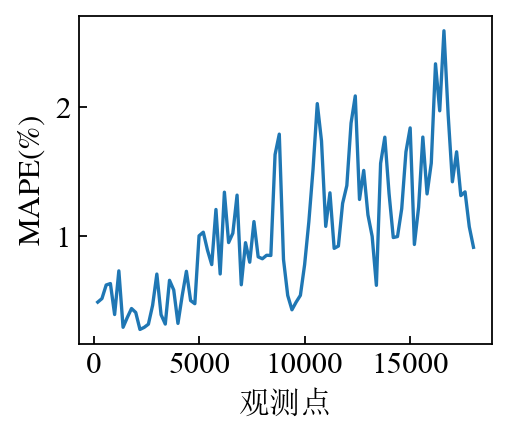

In [78]:
# 绘图
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker

# create figure
config = {
"font.family":'serif',  
"font.size": 14,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}
# 画板设置
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)

# 绘图曲线
h = 0
ax.plot(np.arange(1,mape_window.shape[0]+1)*window_len, mape_window[:,h], color=color_list[1], linestyle='-')

# ax.set_ylim([0,2.5])
#ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('$\mathrm{MAPE(\%)}$', fontfamily="SimSun")
ax.set_xlabel('观测点', fontfamily="SimSun")
# plt.legend(['观测值', '预测轨迹'],frameon=False, fontsize=10, bbox_to_anchor=(0.85, 1.17), prop=legend_font, ncol=2)

In [79]:
def MAPE(y_pred, target):
    loss = ((y_pred - target).abs() / (target.abs() + 1e-8)).mean(0)*100
    return loss

def MAE(y_pred, target):
    loss = (target - y_pred).abs().mean(0)
    return loss

test_multi_step_mae =  MAE(y_pred, y_true)
test_multi_step_mape = MAPE(y_pred, y_true)
index = [0, 4, 9, 14]
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')

net1 MAE:[3.322674512863159, 11.320537567138672, 23.47283935546875, 31.640958786010742], mean:18.126638412475586
net1 MAPE:[1.0334519147872925, 3.4569334983825684, 7.165961742401123, 9.701255798339844], mean:5.544073104858398


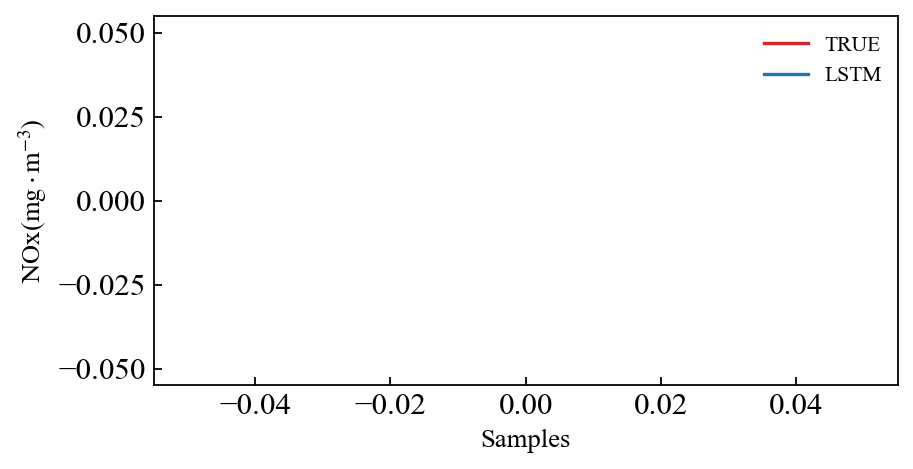

In [96]:
## 画图
## 画图
config = {
"font.family":"times new roman",    
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
    
"ytick.direction":"in",
}
rcParams.update(config)

h = 10
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
plt.figure(dpi=160, figsize=(6,3))
plt.plot(y_true[2500:3000,h],color = color_list[4],linewidth=1.5)
plt.plot(y_pred[2500:3000,h],color = color_list[0],linewidth=1.5)


plt.xlabel("Samples",{"size":12})
plt.ylabel("NOx($\mathrm{mg \cdot m^{-3}}$)",{"size":12})
plt.legend(['TRUE', 'LSTM'],frameon=False, fontsize = 'x-small',bbox_to_anchor=(1.005, 1) )

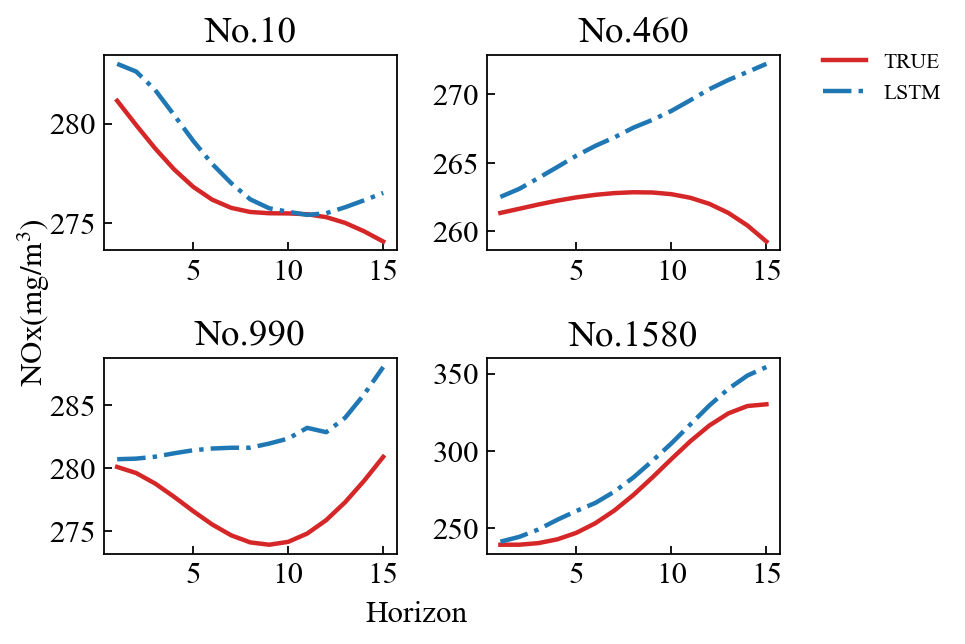

In [94]:
config = {
"font.family":'serif',  
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
x = np.arange(1,16)
fig, ax1 = plt.subplots(2,2, figsize=(5,4), dpi=160)


point = 100
ax1[0,0].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[0,0].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)
ax1[0,0].set_title('No.10')


point = 400
ax1[0,1].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[0,1].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)
ax1[0,1].set_title('No.460')

point = 500
ax1[1,0].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[1,0].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)

ax1[1,0].set_title('No.990')

point = 14000   # 1380
ax1[1,1].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[1,1].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)

ax1[1,1].set_title('No.1580')
#ax1[1,1].set_ylim([290,320])

egend_font = {"family" : "serif"}
fig.legend(['TRUE', 'LSTM', ],frameon=False,\
           fontsize='x-small', bbox_to_anchor=(1.18, 0.92))

fig.text(0.5, 0, "Horizon", ha='center')
fig.text(0, 0.5, "NOx($\mathrm{mg/m^{3}}$)", va='center', rotation='vertical')   
plt.tight_layout()